In [ ]:
#!sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
!tar xf spark-3.2.4-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import findspark
findspark.init("/content/spark-3.2.4-bin-hadoop3.2")

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set(color_codes=True)

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
font_name = fm.FontProperties(fname=fontpath).get_name()
plt.rc('font', family='NanumBarunGothic')
#mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


# PCA

### *Wine Dataset*

**data load**

In [ ]:
wine = spark.read.option("header", "true") \
                    .option("inferSchema", "true") \
                    .csv('/content/drive/MyDrive/data/wine.csv')

wine.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|          8.9|            0.12|       0.45|           1.8|    0.075|               10.0|                21.0|0.99552|3.41|     0.76|   11.9|      7|    0|
|          5.6|            0.19|       0.46|           1.1|    0.032|               33.0|               115.0| 0.9909|3.36|      0.5|   10.4|      6|    1|
|          6.0|            0.26|       0.32|           3.5|    0.028|               29.0|               113.0| 0.9912| 3.4|     0.71|   12.3|      7|    1|
|          6.2|            0.25|       0.38|           7.9|    0

**feature vector 만들기**

In [ ]:
from pyspark.ml.feature import VectorAssembler
# remove label column
cols = wine.columns
cols.remove('label')

assembler = "fill here"() \
    .setInputCols(cols)\
    .setOutputCol("features")

wine_assem = assembler."fill here"(wine)

**Scaler & PCA fit**

Biplot 에서 arrow 를 그리기 수월하도록 Scaler option 중 setWithMean 을 True 로 하였습니다. 이 옵션이 true 가 되어야 features_scaled 값이 Mean 이 0 이 되도록 scaling 하게 되며, pca_features 도 그에 맞게 조절 됩니다. 이렇게 되어야 0,0 에서 출발하는 화살표를 그릴 수 있습니다.

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline

# scale feature vector
standardScaler = StandardScaler()\
    .setWithMean(True)\
    .setWithStd(True)\
    .setInputCol("features")\
    .setOutputCol("features_scaled")

pca = PCA(k=2, inputCol="features_scaled", outputCol="pca_features")

pipeline = Pipeline(stages=[assembler, standardScaler, pca])
pipelineModel = pipeline.fit(wine)

In [ ]:
wine_pca = pipelineModel."fill here"(wine)
wine_pca.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|            features|     features_scaled|        pca_features|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+--------------------+
|          8.9|            0.12|       0.45|           1.8|    0.075|               10.0|                21.0|0.99552|3.41|     0.76|   11.9|      7|    0|[8.9,0.12,0.45,1....|[1.29948246492746...|[-2.0577767488676...|
|          5.6|            0.19|       0.46|           1.1|    0.032|               33.0|               115.0| 0.9909|3.36| 

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)

df_wine = wine_pca.withColumn("pca", to_array(col("pca_features")))\
                    .select(["label", "quality"] + [col("pca")[i] for i in range(2)])\
                    .toPandas()
df_wine.head()

,label,quality,pca[0],pca[1]
0,0,7,-2.057777,-0.984942
1,1,6,0.817884,-1.651968
2,1,7,0.036338,-2.491674
3,1,5,2.236543,1.303567
4,0,5,-2.194082,0.477332


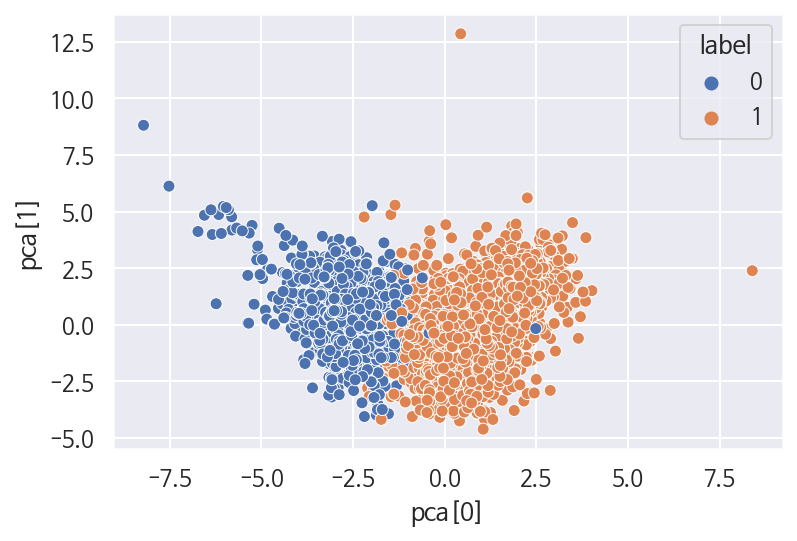

In [ ]:
import seaborn as sns
plt.rc('axes', unicode_minus=False)
ax = sns.scatterplot(x='pca[0]', y='pca[1]', hue='label', data=df_wine)

In [ ]:
# Returns a vector of proportions of variance explained by each principal component.
pcaModel = pipelineModel.stages[-1]
pcaModel.explainedVariance.toArray()

array([0.25346226, 0.22082117])

In [ ]:
# Returns a principal components Matrix. Each column is one principal component.
list(zip(pcaModel.pc.toArray(), cols))

[(array([-0.25692873,  0.26184306]), 'fixed acidity'),
 (array([-0.39493118,  0.10519825]), 'volatile acidity'),
 (array([0.14646061, 0.14409348]), 'citric acid'),
 (array([0.31890519, 0.34258497]), 'residual sugar'),
 (array([-0.31344994,  0.2697701 ]), 'chlorides'),
 (array([0.42269137, 0.11117878]), 'free sulfur dioxide'),
 (array([0.47441968, 0.14394753]), 'total sulfur dioxide'),
 (array([-0.09243753,  0.55492047]), 'density'),
 (array([-0.20806957, -0.15292185]), 'pH'),
 (array([-0.29985192,  0.1196342 ]), 'sulphates'),
 (array([-0.05892408, -0.49272747]), 'alcohol'),
 (array([ 0.08747571, -0.29660091]), 'quality')]

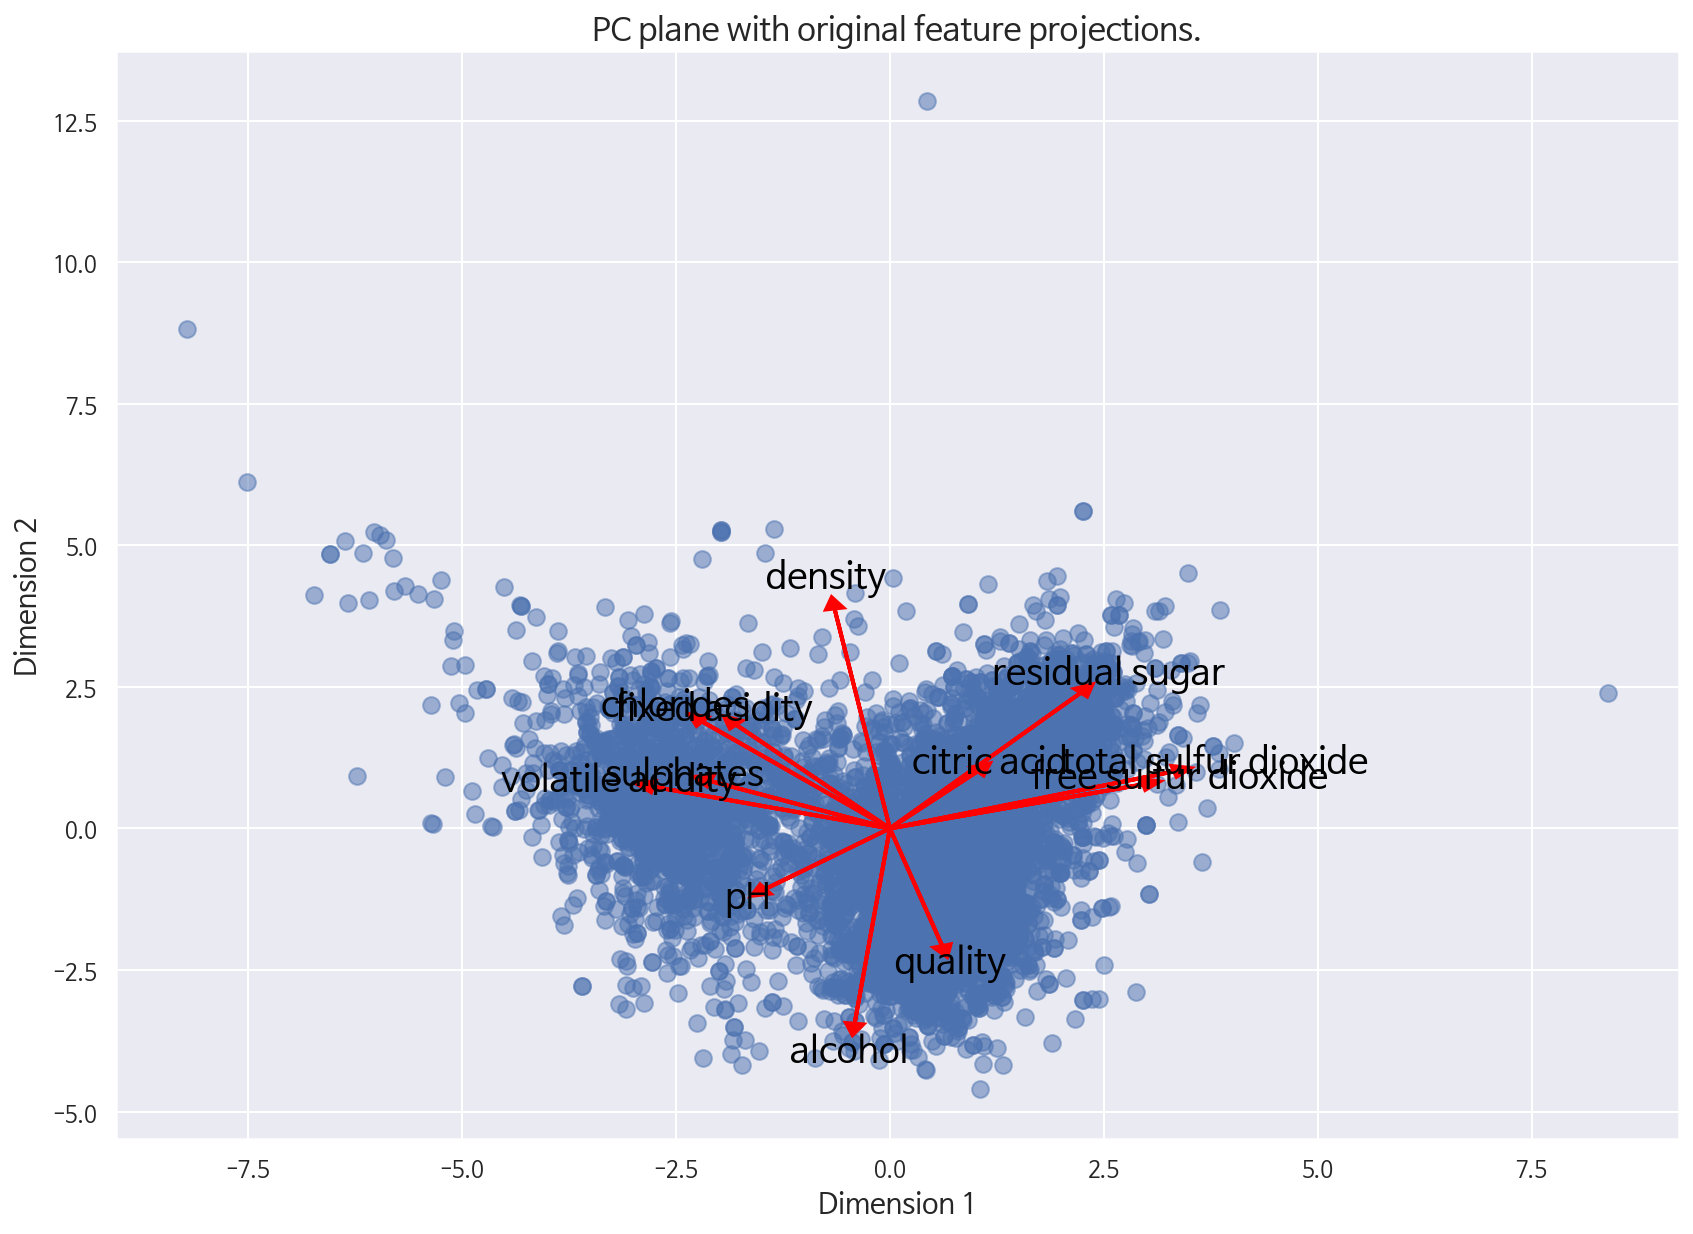

In [ ]:
import matplotlib.pylab as plt

def biplot(data, reduced_data, model):

    fig, ax = plt.subplots(figsize = (14,10))

    # scatterplot of the reduced data
    ax.scatter(x=reduced_data.loc[:, 'pca[0]'], y=reduced_data.loc[:, 'pca[1]'], facecolors='b', edgecolors='b', s=70, alpha=0.5)

    feature_vectors = model.pc.toArray()

    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

original_data = wine.toPandas().drop(['label'], axis=1)
biplot(original_data, df_wine, pcaModel)


# *도전과제*

quality, label둘다 제외하고 pca후 quality값을 이용해 시각화 해보기


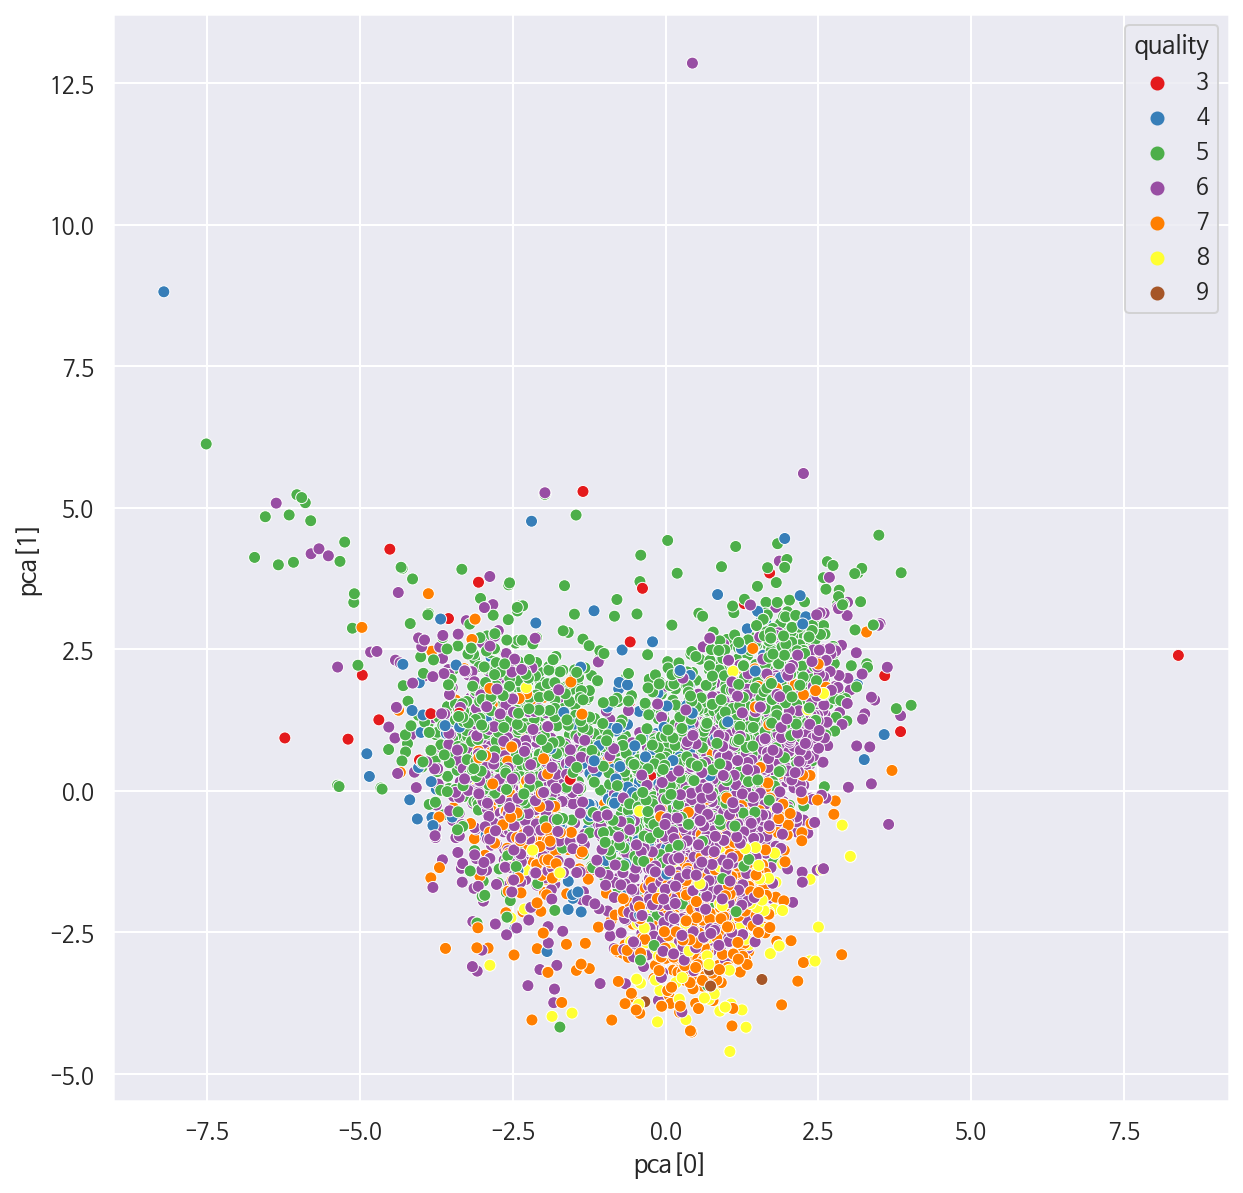

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="fill here", y="fill here", hue="fill here", data=df_wine, palette="Set1")

# Dendrogram

### *Iris Dataset*

In [ ]:
import seaborn as sns
sns.set(color_codes=True)

In [ ]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


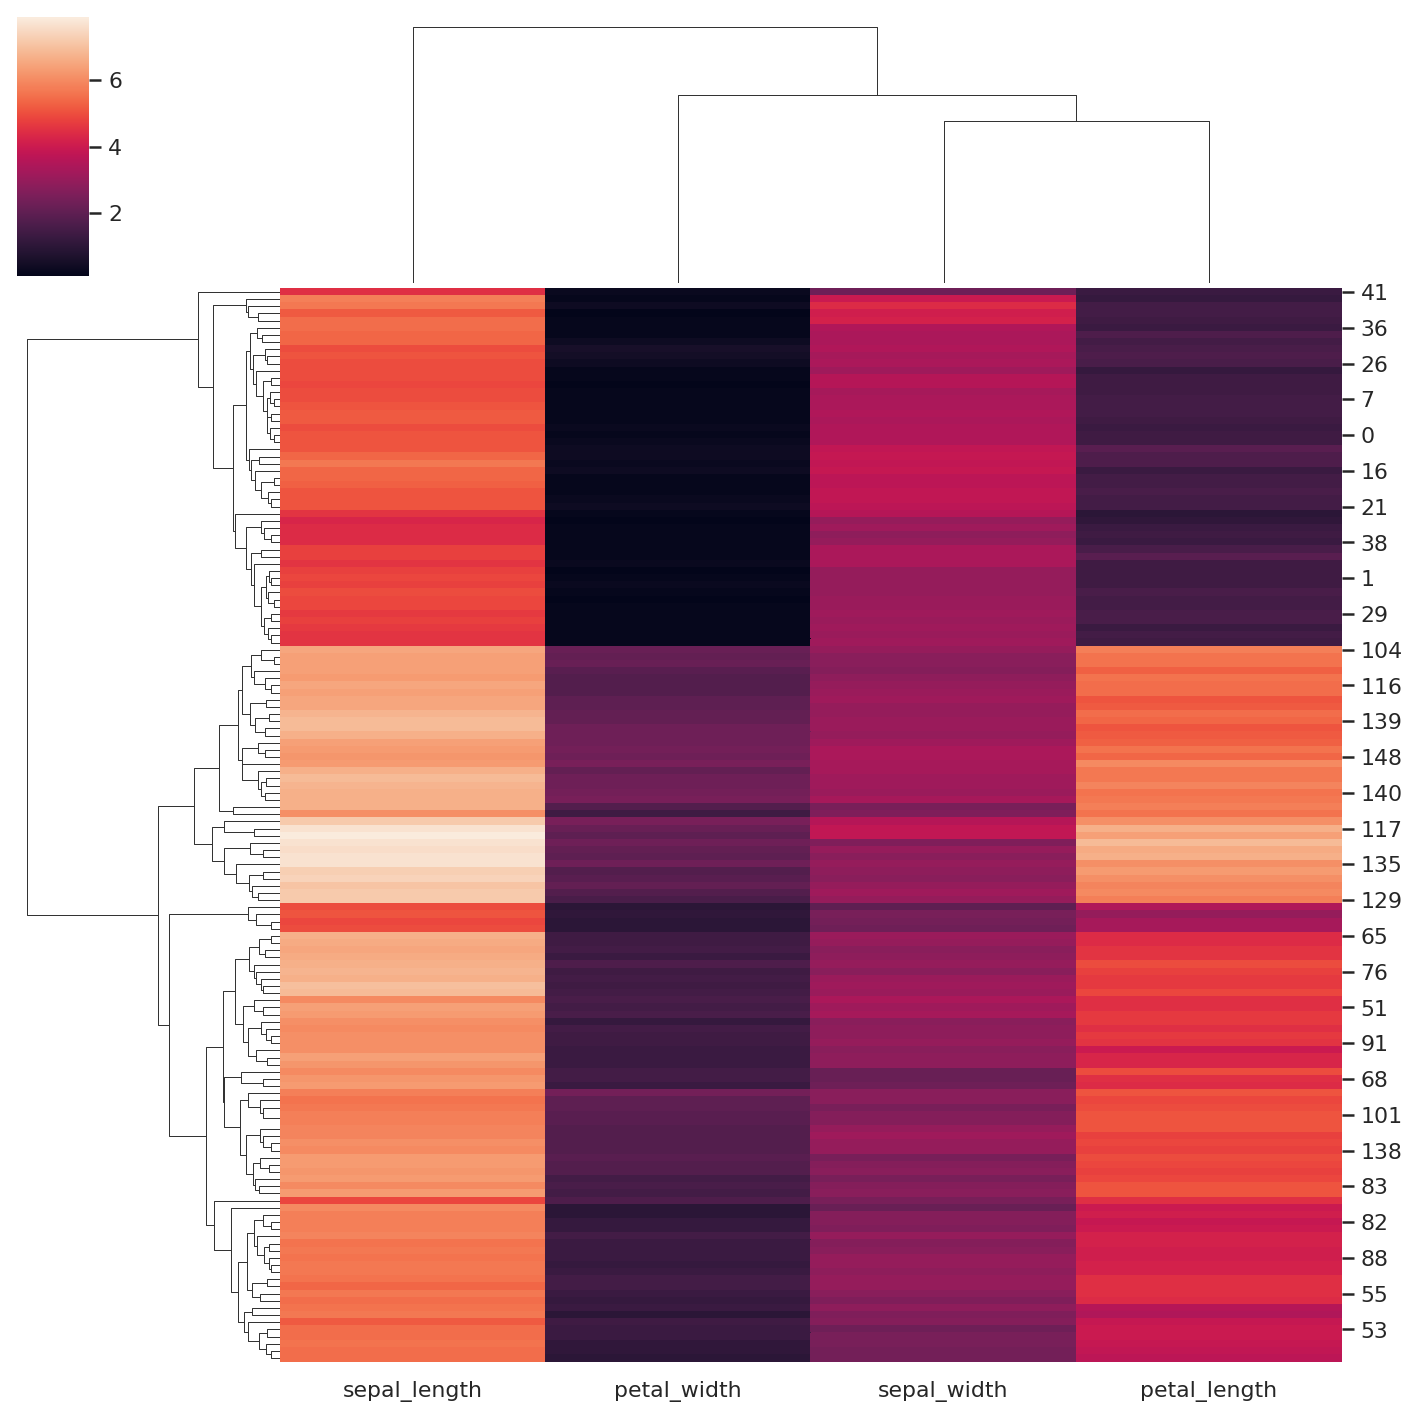

In [ ]:
# remove label
species = iris.pop("species")
g = sns.clustermap(iris)

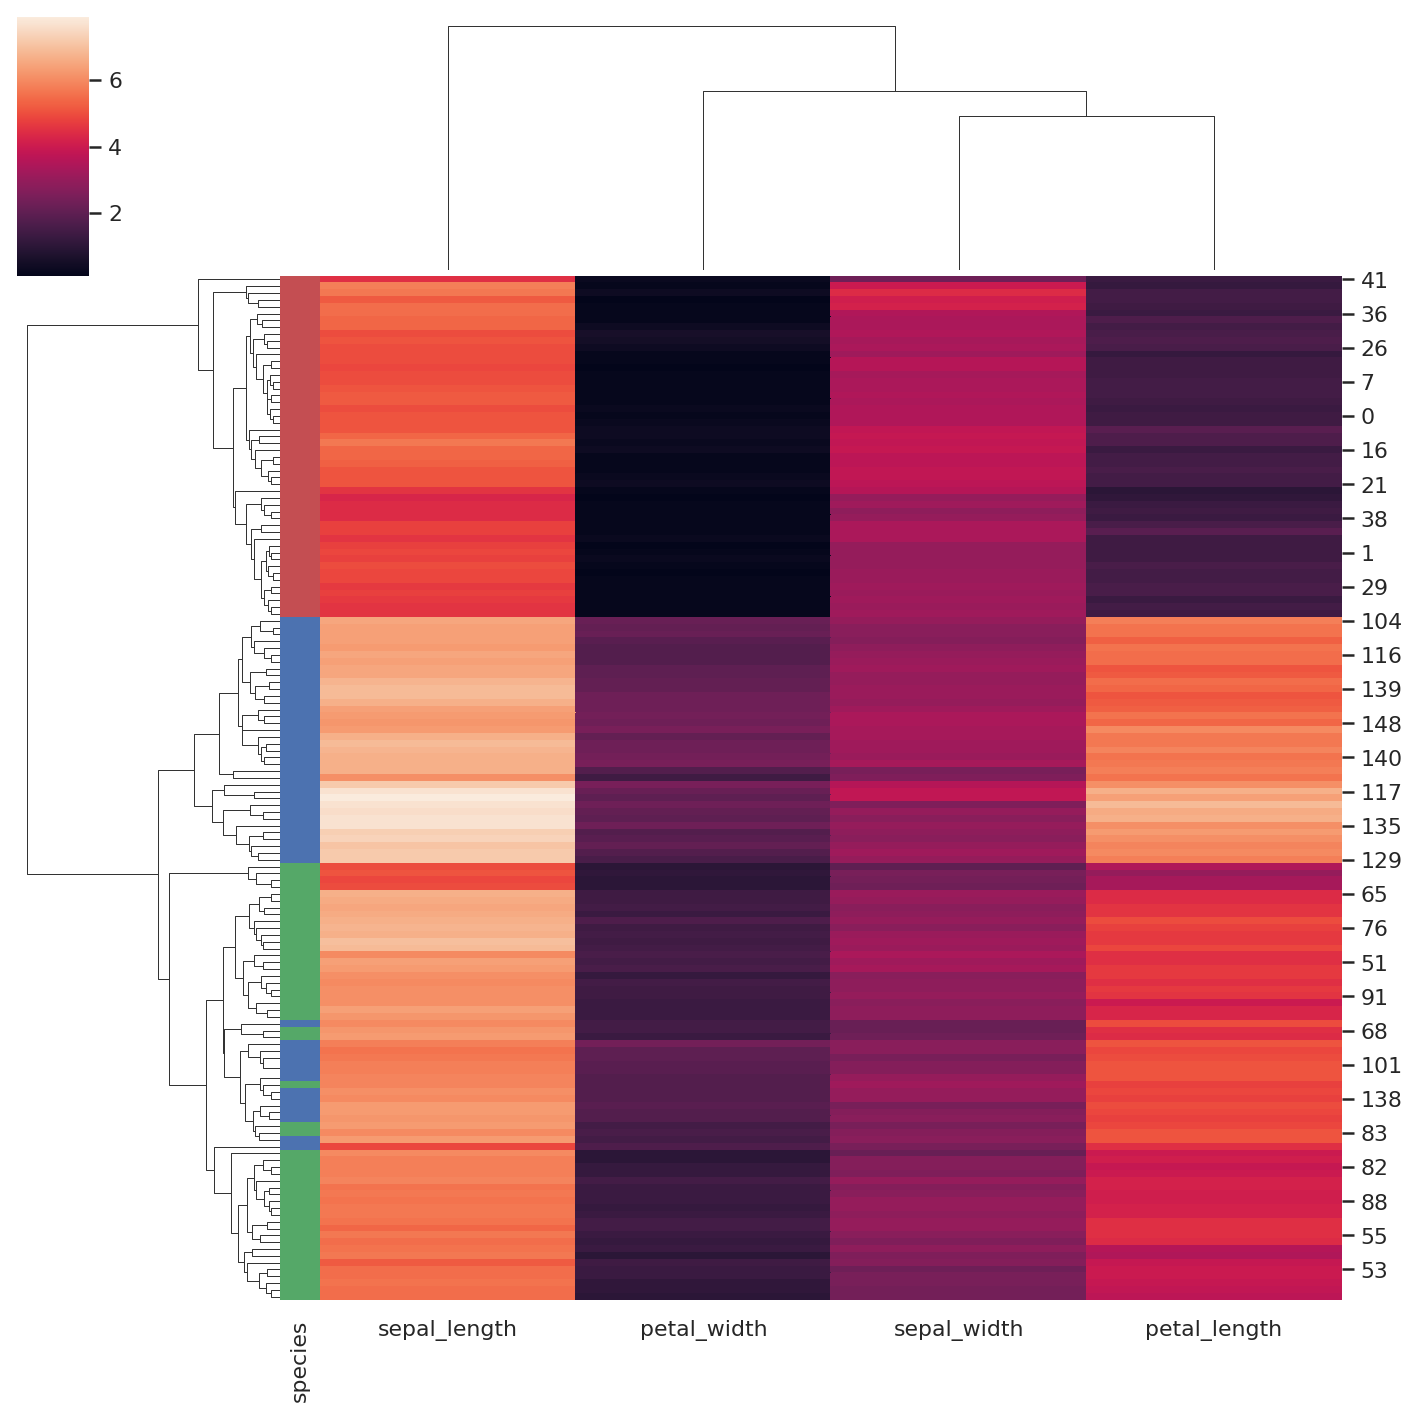

In [ ]:
# rgb colors for species
lut = dict(zip(species.unique(), "rgb"))
row_colors = species.map(lut)
g = sns.clustermap(iris, row_colors=row_colors)

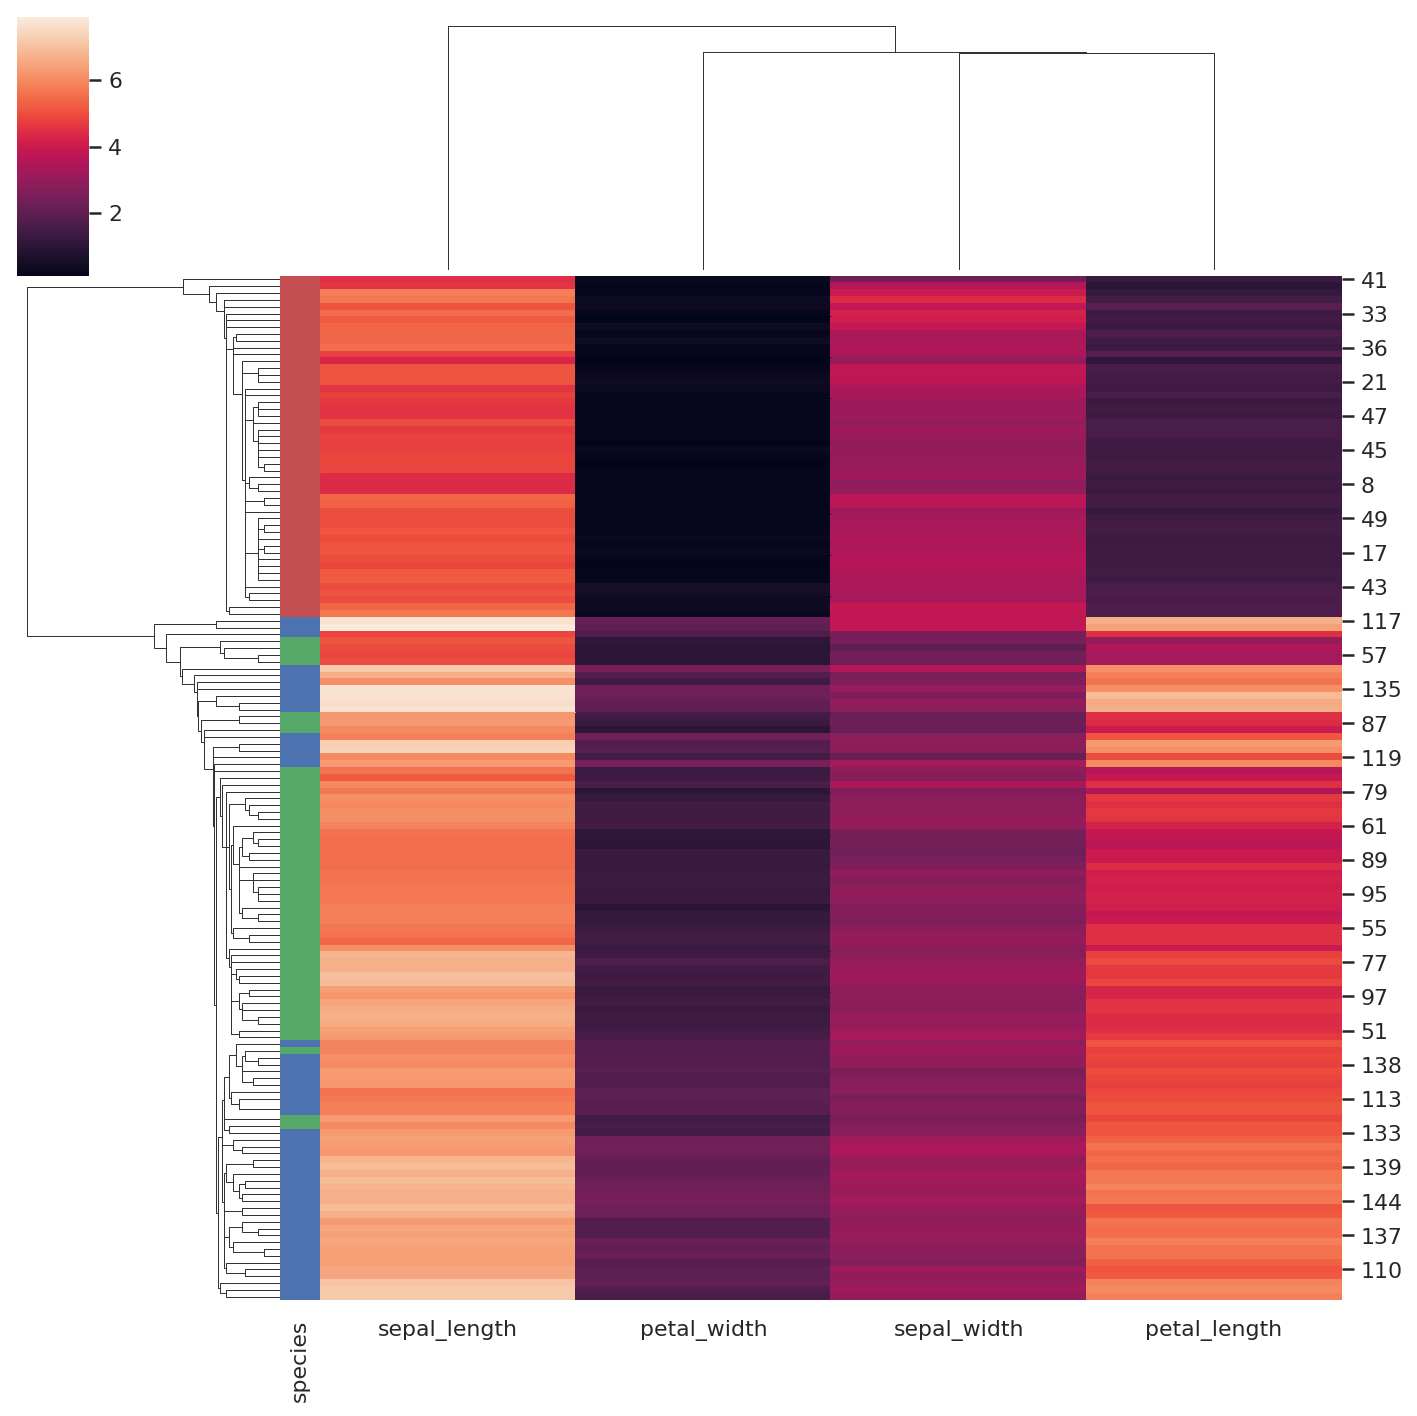

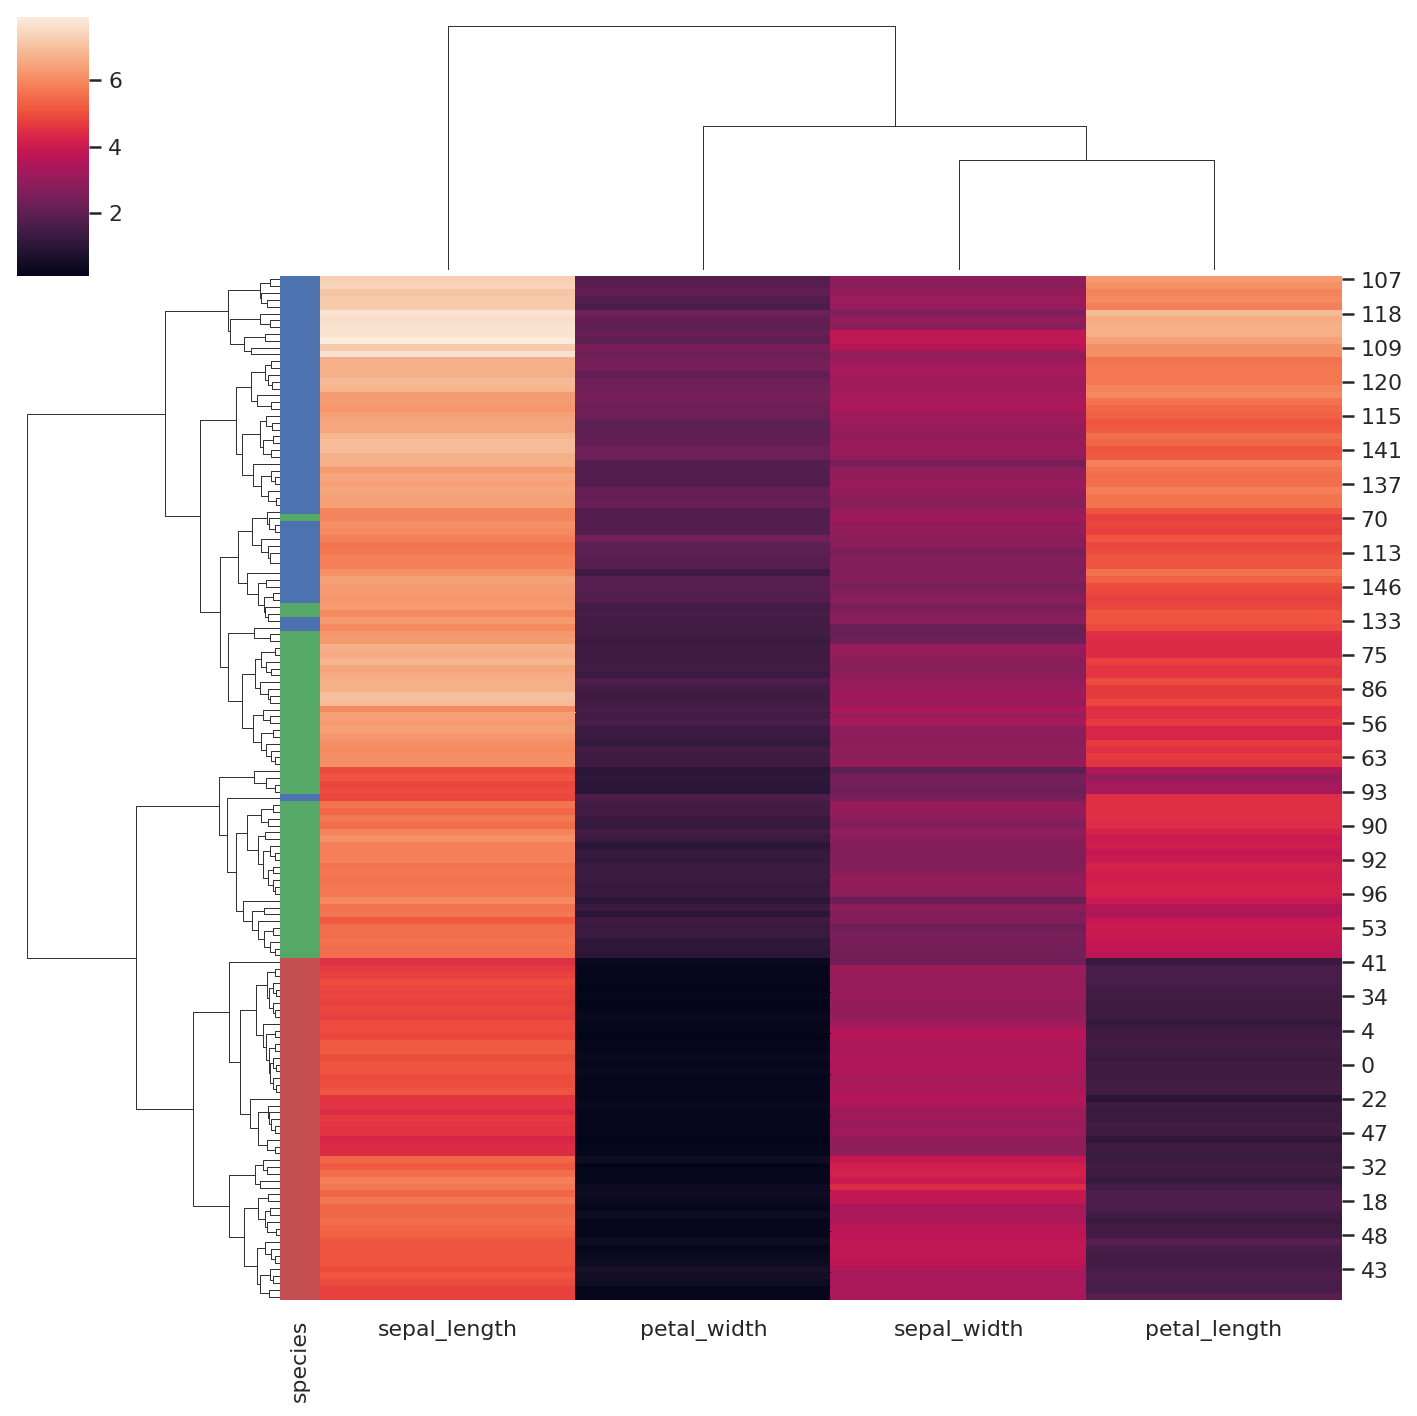

In [ ]:
# compare linkage methods: 'complete', 'single'
lut = dict(zip(species.unique(), "rgb"))
row_colors = species.map(lut)

g = sns.clustermap(iris, row_colors=row_colors, method='single')
g = sns.clustermap(iris, row_colors=row_colors, method='complete')

### 미세먼지 data

In [ ]:
# Load data
df_mise = spark.read.option("header", "true") \
                    .option("inferSchema", "true") \
                    .csv('/content/drive/MyDrive/mise04.csv')

df_mise.show()

+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|      구|2018-04-01|2018-04-02|2018-04-03|2018-04-04|2018-04-05|2018-04-06|2018-04-07|2018-04-08|2018-04-09|2018-04-10|2018-04-11|2018-04-12|2018-04-13|2018-04-14|2018-04-15|2018-04-16|2018-04-17|2018-04-18|2018-04-19|2018-04-20|2018-04-21|2018-04-22|2018-04-23|2018-04-24|2018-04-25|2018-04-26|2018-04-27|2018-04-28|2018-04-29|2018-04-30|
+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-

In [ ]:
mise = df_mise.toPandas()
mise.head()

,구,2018-04-01,2018-04-02,2018-04-03,2018-04-04,2018-04-05,2018-04-06,2018-04-07,2018-04-08,2018-04-09,...,2018-04-21,2018-04-22,2018-04-23,2018-04-24,2018-04-25,2018-04-26,2018-04-27,2018-04-28,2018-04-29,2018-04-30
0,종로구,27,24,17,5,4,21,20,13,22,...,35,18,6,4,22.0,26,34,34,28,47
1,중구,28,22,16,6,5,19,19,12,24,...,36,18,6,5,21.0,27,36,36,29,50
2,용산구,40,33,25,8,4,32,26,17,29,...,43,20,5,4,26.0,30,42,42,34,58
3,성동구,43,35,26,9,6,30,27,17,23,...,51,27,8,4,NaN,38,42,44,38,69
4,광진구,31,24,18,6,4,21,21,13,21,...,38,18,5,5,22.0,27,34,38,29,50


In [ ]:
mise2 = mise.set_index('구').fillna(mise.median())
mise2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,2018-04-01,2018-04-02,2018-04-03,2018-04-04,2018-04-05,2018-04-06,2018-04-07,2018-04-08,2018-04-09,2018-04-10,...,2018-04-21,2018-04-22,2018-04-23,2018-04-24,2018-04-25,2018-04-26,2018-04-27,2018-04-28,2018-04-29,2018-04-30
구,,,,,,,,,,,,,,,,,,,,,
종로구,27,24,17,5,4,21,20,13,22,18,...,35,18,6,4,22.0,26,34,34,28,47
중구,28,22,16,6,5,19,19,12,24,18,...,36,18,6,5,21.0,27,36,36,29,50
용산구,40,33,25,8,4,32,26,17,29,21,...,43,20,5,4,26.0,30,42,42,34,58
성동구,43,35,26,9,6,30,27,17,23,21,...,51,27,8,4,23.0,38,42,44,38,69
광진구,31,24,18,6,4,21,21,13,21,18,...,38,18,5,5,22.0,27,34,38,29,50


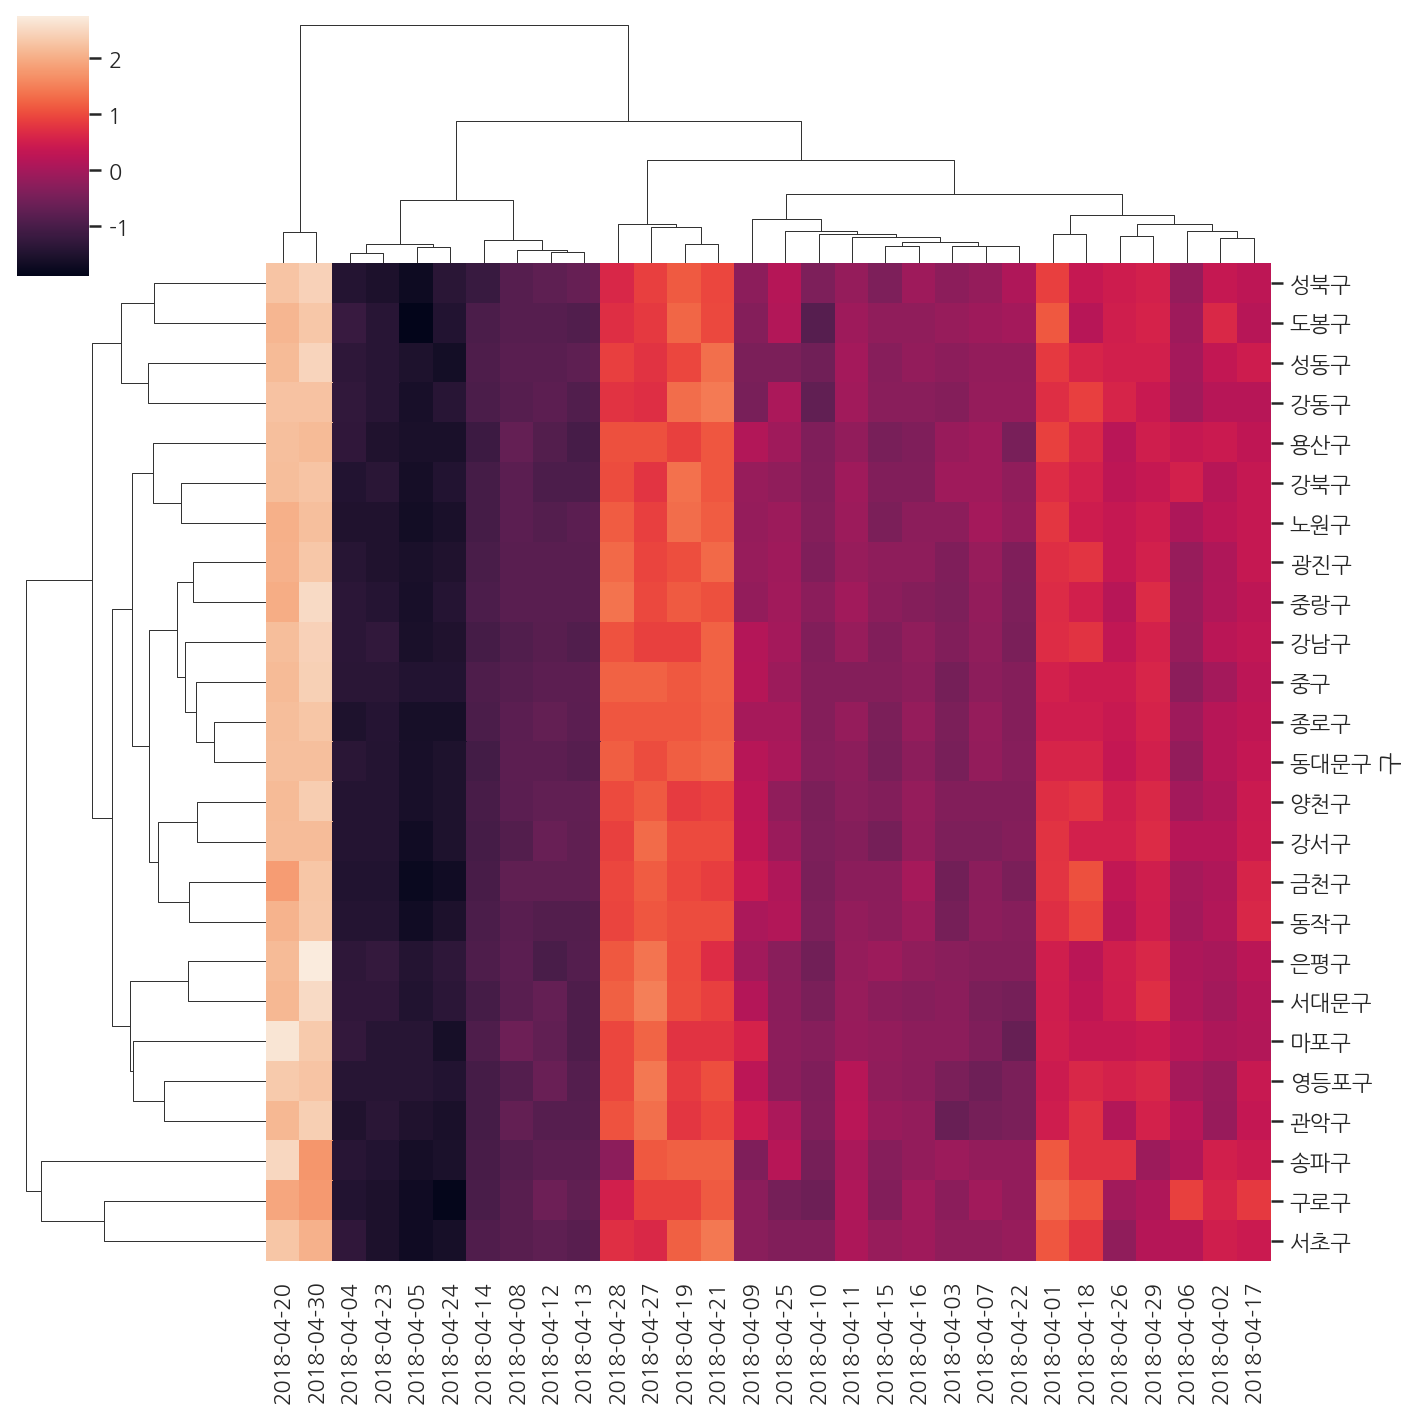

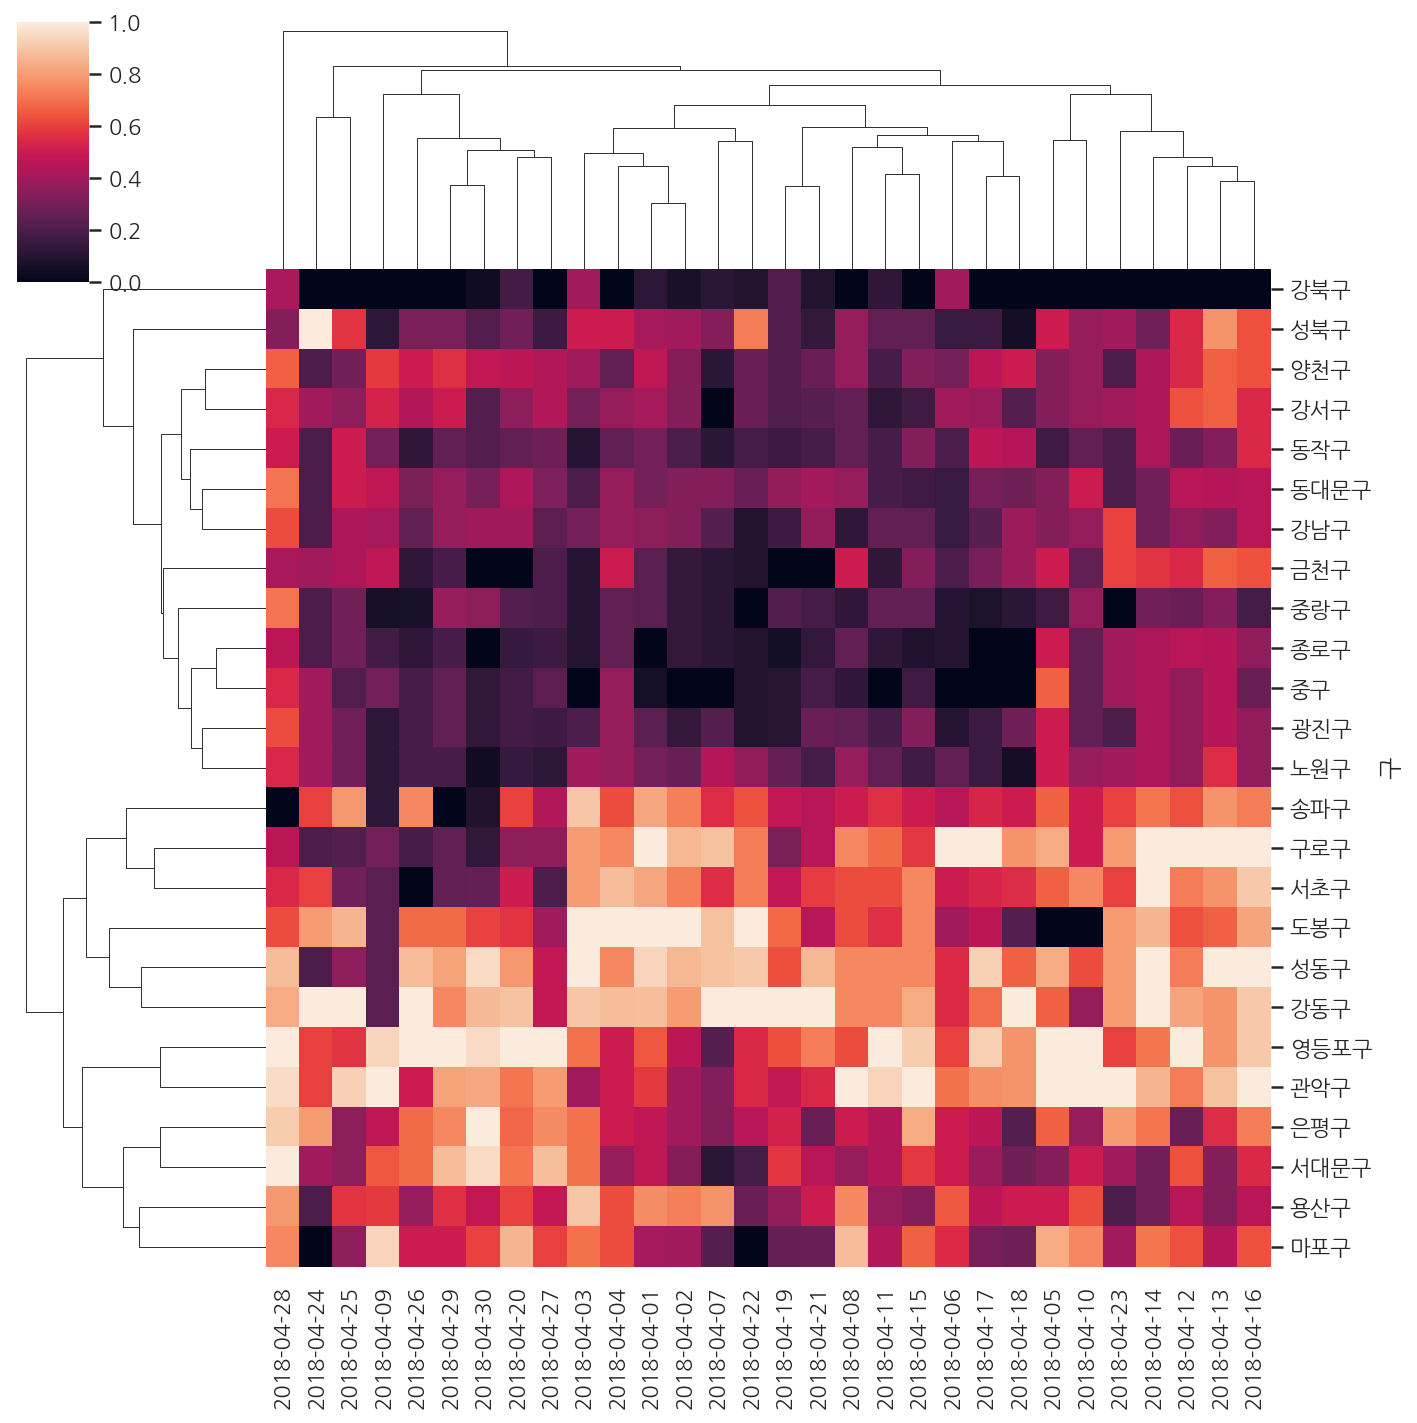

In [ ]:
# Normalize the data within the rows
# "미세먼지 농도가 비슷했던 날짜들끼리 묶어보기"
# "미세먼지 농도가 비슷했던 구 단위를 묶어보기"
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
g = sns.clustermap(mise2, z_score=0)

# Standardize the data within the columns
g = sns.clustermap(mise2, standard_scale=1)

# K-means

### *KDD Cup 1999 Data Set*

In [ ]:
# Load data
dataWithoutHeader = spark.read.option("header", "false") \
                    .option("inferSchema", "true") \
                    .csv('/content/drive/MyDrive/kddcup.data_10_percent_corrected')

data = dataWithoutHeader.toDF(
    "duration", "protocol_type", "service", "flag",
    "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
    "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count",
    "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "label")

# 총 23종류의 레이블 존재
data.select("label")\
    .groupBy("label")\
    .count()\
    .orderBy("count", ascending=False)\
    .show(10)

+------------+------+
|       label| count|
+------------+------+
|      smurf.|280790|
|    neptune.|107201|
|     normal.| 97278|
|       back.|  2203|
|      satan.|  1589|
|    ipsweep.|  1247|
|  portsweep.|  1040|
|warezclient.|  1020|
|   teardrop.|   979|
|        pod.|   264|
+------------+------+
only showing top 10 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

# use only numeric column
numericOnly = data.drop("protocol_type", "service", "flag").dropna().cache()

In [ ]:
cols = numericOnly.columns.copy()
cols.remove("label")

assembler = VectorAssembler() \
    .setInputCols(cols)\
    .setOutputCol("features")

kmeans = KMeans()

evaluator = ClusteringEvaluator()

In [ ]:
pipeline = Pipeline().setStages([assembler, kmeans])
pipelineModel = pipeline.fit(numericOnly)
kmeansModel = pipelineModel.stages[-1]

kmeansModel.clusterCenters() # k=2 (default)

[array([4.79793956e+01, 1.62207883e+03, 8.68534183e+02, 4.45326100e-05,
        6.43293794e-03, 1.41694668e-05, 3.45168212e-02, 1.51815716e-04,
        1.48247035e-01, 1.02121372e-02, 1.11331525e-04, 3.64357718e-05,
        1.13517671e-02, 1.08295211e-03, 1.09307315e-04, 1.00805635e-03,
        0.00000000e+00, 0.00000000e+00, 1.38658354e-03, 3.32286248e+02,
        2.92907143e+02, 1.76685418e-01, 1.76607809e-01, 5.74330999e-02,
        5.77183920e-02, 7.91548844e-01, 2.09816404e-02, 2.89968625e-02,
        2.32470732e+02, 1.88666046e+02, 7.53781203e-01, 3.09056111e-02,
        6.01935529e-01, 6.68351484e-03, 1.76753957e-01, 1.76441622e-01,
        5.81176268e-02, 5.74111170e-02]),
 array([2.0000000e+00, 6.9337564e+08, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 

In [ ]:
withCluster = pipelineModel.transform(numericOnly)

withCluster.select("prediction", "label") \
    .groupBy("prediction", "label").count() \
    .orderBy(["prediction", "count"], ascending=[1, 0]) \
    .show(50)

+----------+----------------+------+
|prediction|           label| count|
+----------+----------------+------+
|         0|          smurf.|280790|
|         0|        neptune.|107201|
|         0|         normal.| 97278|
|         0|           back.|  2203|
|         0|          satan.|  1589|
|         0|        ipsweep.|  1247|
|         0|      portsweep.|  1039|
|         0|    warezclient.|  1020|
|         0|       teardrop.|   979|
|         0|            pod.|   264|
|         0|           nmap.|   231|
|         0|   guess_passwd.|    53|
|         0|buffer_overflow.|    30|
|         0|           land.|    21|
|         0|    warezmaster.|    20|
|         0|           imap.|    12|
|         0|        rootkit.|    10|
|         0|     loadmodule.|     9|
|         0|      ftp_write.|     8|
|         0|       multihop.|     7|
|         0|            phf.|     4|
|         0|           perl.|     3|
|         0|            spy.|     2|
|         1|      portsweep.|     1|
+

 **Choosing K**

In [ ]:
def clusteringScore0(data, k): # (data: DataFrame, k: Int): Double
    cols = data.columns.copy()
    cols.remove("label")

    assembler = VectorAssembler() \
        .setInputCols(cols) \
        .setOutputCol("features")

    kmeans = KMeans() \
        .setK(k) \
        .setFeaturesCol("features")

    pipeline = Pipeline().setStages([assembler, kmeans])
    pipelineModel = pipeline.fit(data)
    kmeansModel = pipelineModel.stages[-1]
    silhouette = evaluator.evaluate(pipelineModel.transform(data))

    return silhouette

In [ ]:
scores0 = map(lambda x: (x, clusteringScore0(numericOnly, x)), range(20, 161, 20))
list(scores0)

[(20, 0.9926296579876106),
 (40, 0.9943275707619305),
 (60, 0.961846572786634),
 (80, 0.9627165791450076),
 (100, 0.9583696405062655),
 (120, 0.9655631063272359),
 (140, 0.9641517011178877),
 (160, 0.9385612774531931)]

In [ ]:
# Increase maximum iteration and decrease tolerance
def clusteringScore1(data, k): # clusteringScore1 (data: DataFrame, k: Int): Double
    cols = data.columns.copy()
    cols.remove("label")

    assembler = VectorAssembler() \
        .setInputCols(cols) \
        .setOutputCol("features")

    kmeans = KMeans() \
        .setK(k) \
        .setMaxIter(50) \
        .setTol(1.0e-5) \
        .setFeaturesCol("features")

    pipeline = Pipeline().setStages([assembler, kmeans])
    pipelineModel = pipeline.fit(data)
    kmeansModel = pipelineModel.stages[-1]
    silhouette = evaluator.evaluate(pipelineModel.transform(data))

    return silhouette

In [ ]:
scores1 = map(lambda x: (x, clusteringScore1(numericOnly, x)), range(20, 161, 20))
list(scores1)

[(20, 0.9926296579876106),
 (40, 0.9943275707619305),
 (60, 0.961846572786634),
 (80, 0.9627221396108964),
 (100, 0.9583771712096907),
 (120, 0.9653665646469507),
 (140, 0.9641552329581573),
 (160, 0.9391303684136213)]

**Normalize**

In [ ]:
# normalize features
from pyspark.ml.feature import StandardScaler

def clusteringScore2(data, k): # def clusteringScore2(data: DataFrame, k: Int): Double
    cols = data.columns.copy()
    cols.remove("label")

    assembler = VectorAssembler() \
        .setInputCols(cols) \
        .setOutputCol("features")

    scaler = StandardScaler() \
        .setInputCol("features") \
        .setOutputCol("features_scaled") \
        .setWithStd(True) \
        .setWithMean(False)

    kmeans = KMeans() \
        .setK(k) \
        .setMaxIter(40) \
        .setTol(1.0e-5) \
        .setFeaturesCol("features_scaled")

    pipeline = Pipeline().setStages([assembler, scaler, kmeans])
    pipelineModel = pipeline.fit(data)
    kmeansModel = pipelineModel.stages[-1]
    silhouette = evaluator.evaluate(pipelineModel.transform(data))

    return silhouette

In [ ]:
scores2 = map(lambda x: (x, clusteringScore2(numericOnly, x)), range(20, 161, 20))
list(scores2)

[(20, 0.3743846122050457),
 (40, 0.07368276787788107),
 (60, 0.077963071727698),
 (80, 0.3264928632935248),
 (100, 0.14026303341692484),
 (120, 0.2659332908753712),
 (140, 0.18474520793053265),
 (160, 0.2264373273961763)]

**Using Categorical Data**

In [ ]:
# OneHotEncoder example
from pyspark.ml.feature import OneHotEncoder

df = spark.createDataFrame([
    (0.0, 1.0),
    (1.0, 0.0),
    (2.0, 1.0),
    (0.0, 2.0),
    (0.0, 1.0),
    (2.0, 0.0)
], ["categoryIndex1", "categoryIndex2"])

encoder = OneHotEncoder(inputCols=["categoryIndex1", "categoryIndex2"],
                                 outputCols=["categoryVec1", "categoryVec2"])
model = encoder.fit(df)
encoded = model.transform(df)
encoded.show()

+--------------+--------------+-------------+-------------+
|categoryIndex1|categoryIndex2| categoryVec1| categoryVec2|
+--------------+--------------+-------------+-------------+
|           0.0|           1.0|(2,[0],[1.0])|(2,[1],[1.0])|
|           1.0|           0.0|(2,[1],[1.0])|(2,[0],[1.0])|
|           2.0|           1.0|    (2,[],[])|(2,[1],[1.0])|
|           0.0|           2.0|(2,[0],[1.0])|    (2,[],[])|
|           0.0|           1.0|(2,[0],[1.0])|(2,[1],[1.0])|
|           2.0|           0.0|    (2,[],[])|(2,[0],[1.0])|
+--------------+--------------+-------------+-------------+



In [ ]:
# adding categorical columns
from pyspark.ml.feature import OneHotEncoder, StringIndexer

def clusteringScore3(data, k): # clusteringScore3(data: DataFrame, k: Int): Double
    cols = data.columns.copy()
    cols_to_encode = ["protocol_type", "service", "flag", ]
    cols_indexed = [ i + "_indexed" for i in cols_to_encode ]
    cols_encoded = [ i + "_vec" for i in cols_indexed ]
    for c in ["label", ] + cols_to_encode:
        cols.remove(c)
    cols.extend(cols_encoded)

    indexer = StringIndexer(inputCols=cols_to_encode, outputCols=cols_indexed)
    encoder = OneHotEncoder(inputCols=cols_indexed, outputCols=cols_encoded)

    assembler = VectorAssembler() \
        .setInputCols(cols) \
        .setOutputCol("features")

    scaler = StandardScaler() \
        .setInputCol("features") \
        .setOutputCol("features_scaled") \
        .setWithStd(True) \
        .setWithMean(False)

    kmeans = KMeans() \
        .setK(k) \
        .setMaxIter(40) \
        .setTol(1.0e-5) \
        .setFeaturesCol("features_scaled")

    pipeline = Pipeline().setStages([indexer, encoder, assembler, scaler, kmeans])
    pipelineModel = pipeline.fit(data)
    kmeansModel = pipelineModel.stages[-1]
    silhouette = evaluator.evaluate(pipelineModel.transform(data))

    return silhouette

In [ ]:
scores3 = map(lambda x: (x, clusteringScore3(data, x)), range(20, 161, 20))
list(scores3)

[(20, 0.1042461389733737),
 (40, 0.1557211007034461),
 (60, 0.1636692411450804),
 (80, 0.16735297607362645),
 (100, 0.185202201668305),
 (120, 0.2838097970136455),
 (140, 0.2889321877477727),
 (160, 0.03653692135271231)]

# *도전과제*
wine data k-means clustering

In [ ]:
wine.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|          8.9|            0.12|       0.45|           1.8|    0.075|               10.0|                21.0|0.99552|3.41|     0.76|   11.9|      7|    0|
|          5.6|            0.19|       0.46|           1.1|    0.032|               33.0|               115.0| 0.9909|3.36|      0.5|   10.4|      6|    1|
|          6.0|            0.26|       0.32|           3.5|    0.028|               29.0|               113.0| 0.9912| 3.4|     0.71|   12.3|      7|    1|
|          6.2|            0.25|       0.38|           7.9|    0

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

def clusteringWineScore(data, k): # def clusteringWineScore(data: DataFrame, k: Int): Double
    cols = data.columns.copy()
    cols.remove("label")
    cols.remove("quality")

    assembler = "fill here"() \
        .setInputCols(cols) \
        .setOutputCol("features")

    scaler = "fill here"() \
        .setInputCol("features") \
        .setOutputCol("features_scaled") \
        .setWithStd(True) \
        .setWithMean(False)

    kmeans = "fill here"() \
        .setK(k) \
        .setMaxIter(40) \
        .setTol(1.0e-5) \
        .setFeaturesCol("features_scaled")

    pipeline = "fill here"().setStages(["fill here"])
    pipelineModel = pipeline."fill here"(data)
    kmeansModel = pipelineModel.stages[-1]
    silhouette = evaluator.evaluate(pipelineModel.transform(data))

    return silhouette

In [ ]:
thresholds = map(lambda x: (x, clusteringWineScore(wine, x)), range(2, 25, 2))
thresholds = list(thresholds)
print(thresholds)

[(2, 0.4356259826377585), (4, 0.3004399363669586), (6, -0.08676607692300212), (8, -0.12309160129152251), (10, -0.17936747405242073), (12, -0.1958084517448664), (14, -0.2241013053267931), (16, -0.2768485106847762), (18, -0.27171796109854585), (20, -0.263866382980515), (22, -0.2795892937105706), (24, -0.28441003574898815)]


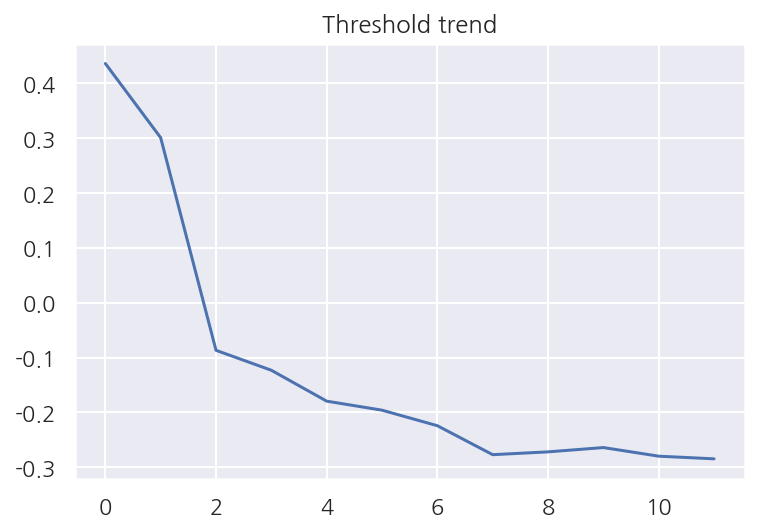

In [ ]:
th = [i[-1] for i in thresholds]
plt.plot(th)
plt.title('Threshold trend')
plt.show()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

def clusteringWine_KM(data, k): # def clusteringWine_KM (data: DataFrame, k: Int): Double
    cols = data.columns.copy()
    cols.remove("label")
    cols.remove("quality")

    assembler = "fill here"() \
        ."fill here"(cols) \
        ."fill here"("features")

    scaler = "fill here"() \
        ."fill here"("features") \
        ."fill here"("features_scaled") \
        ."fill here"(True) \
        ."fill here"(False)

    kmeans = "fill here"() \
        ."fill here"(k) \
        ."fill here"(40) \
        .setTol(1.0e-5) \
        ."fill here"("features_scaled")

    pipeline = "fill here".setStages(["fill here"])
    pipelineModel = pipeline."fill here"(data)
    kmeansModel = pipelineModel.stages[-1]
    return pipelineModel."fill here"(data)

In [ ]:
wine_clustered_KM = clusteringWine_KM(wine, 2)
wine_clustered_KM.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|            features|     features_scaled|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+----------+
|          8.9|            0.12|       0.45|           1.8|    0.075|               10.0|                21.0|0.99552|3.41|     0.76|   11.9|      7|    0|[8.9,0.12,0.45,1....|[6.86498631068064...|         0|
|          5.6|            0.19|       0.46|           1.1|    0.032|               33.0|               115.0| 0.9909|3.36|      0.5|   10.4|      6|    1|[5.6,0.19

**visualization**

In [ ]:
from pyspark.ml.feature import PCA

def clusteringWine_PCA(data, k): # def clusteringWine_PCA (data: DataFrame, k: Int): Double
    cols = wine.columns
    cols.remove('label')
    # cols.remove('quality')

    assembler = "fill here"() \
        ."fill here"(cols)\
        ."fill here"("features")

    scaler = "fill here"()\
        ."fill here"("features")\
        ."fill here"("features_scaled")\
        ."fill here"(True)\
        ."fill here"(False)

    kmeans = "fill here"() \
        ."fill here"(k) \
        ."fill here"(40) \
        ."fill here"(1.0e-5) \
        ."fill here"("features_scaled")

    pca = "fill here"(k=2, inputCol="features_scaled", outputCol="pca_features")
    pipeline ="fill here"(stages=["fill here"])
    pipelineModel = pipeline."fill here"(data)
    kmeansModel = pipelineModel.stages[-1]

    return pipelineModel."fill here"(data)

In [ ]:
wine_pca = clusteringWine_PCA(wine, 2)
wine_pca.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+----------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|            features|     features_scaled|prediction|        pca_features|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+--------------------+----------+--------------------+
|          8.9|            0.12|       0.45|           1.8|    0.075|               10.0|                21.0|0.99552|3.41|     0.76|   11.9|      7|    0|[8.9,0.12,0.45,1....|[6.86498631068064...|         0|[-38.253061086965...|
|          5.6|            0.19|       0.46|           1.1|    0.032|           

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)

df_wine = wine_pca.withColumn("pca", to_array(col("pca_features")))\
                    .select(["label", "quality", "prediction"] + [col("pca")[i] for i in range(2)])\
                    .toPandas()

df_wine.head()

,label,quality,prediction,pca[0],pca[1]
0,0,7,0,-38.253061,177.444187
1,1,6,0,-35.377401,176.777160
2,1,7,0,-36.158947,175.937455
3,1,5,1,-33.958741,179.732695
4,0,5,0,-38.389366,178.906460


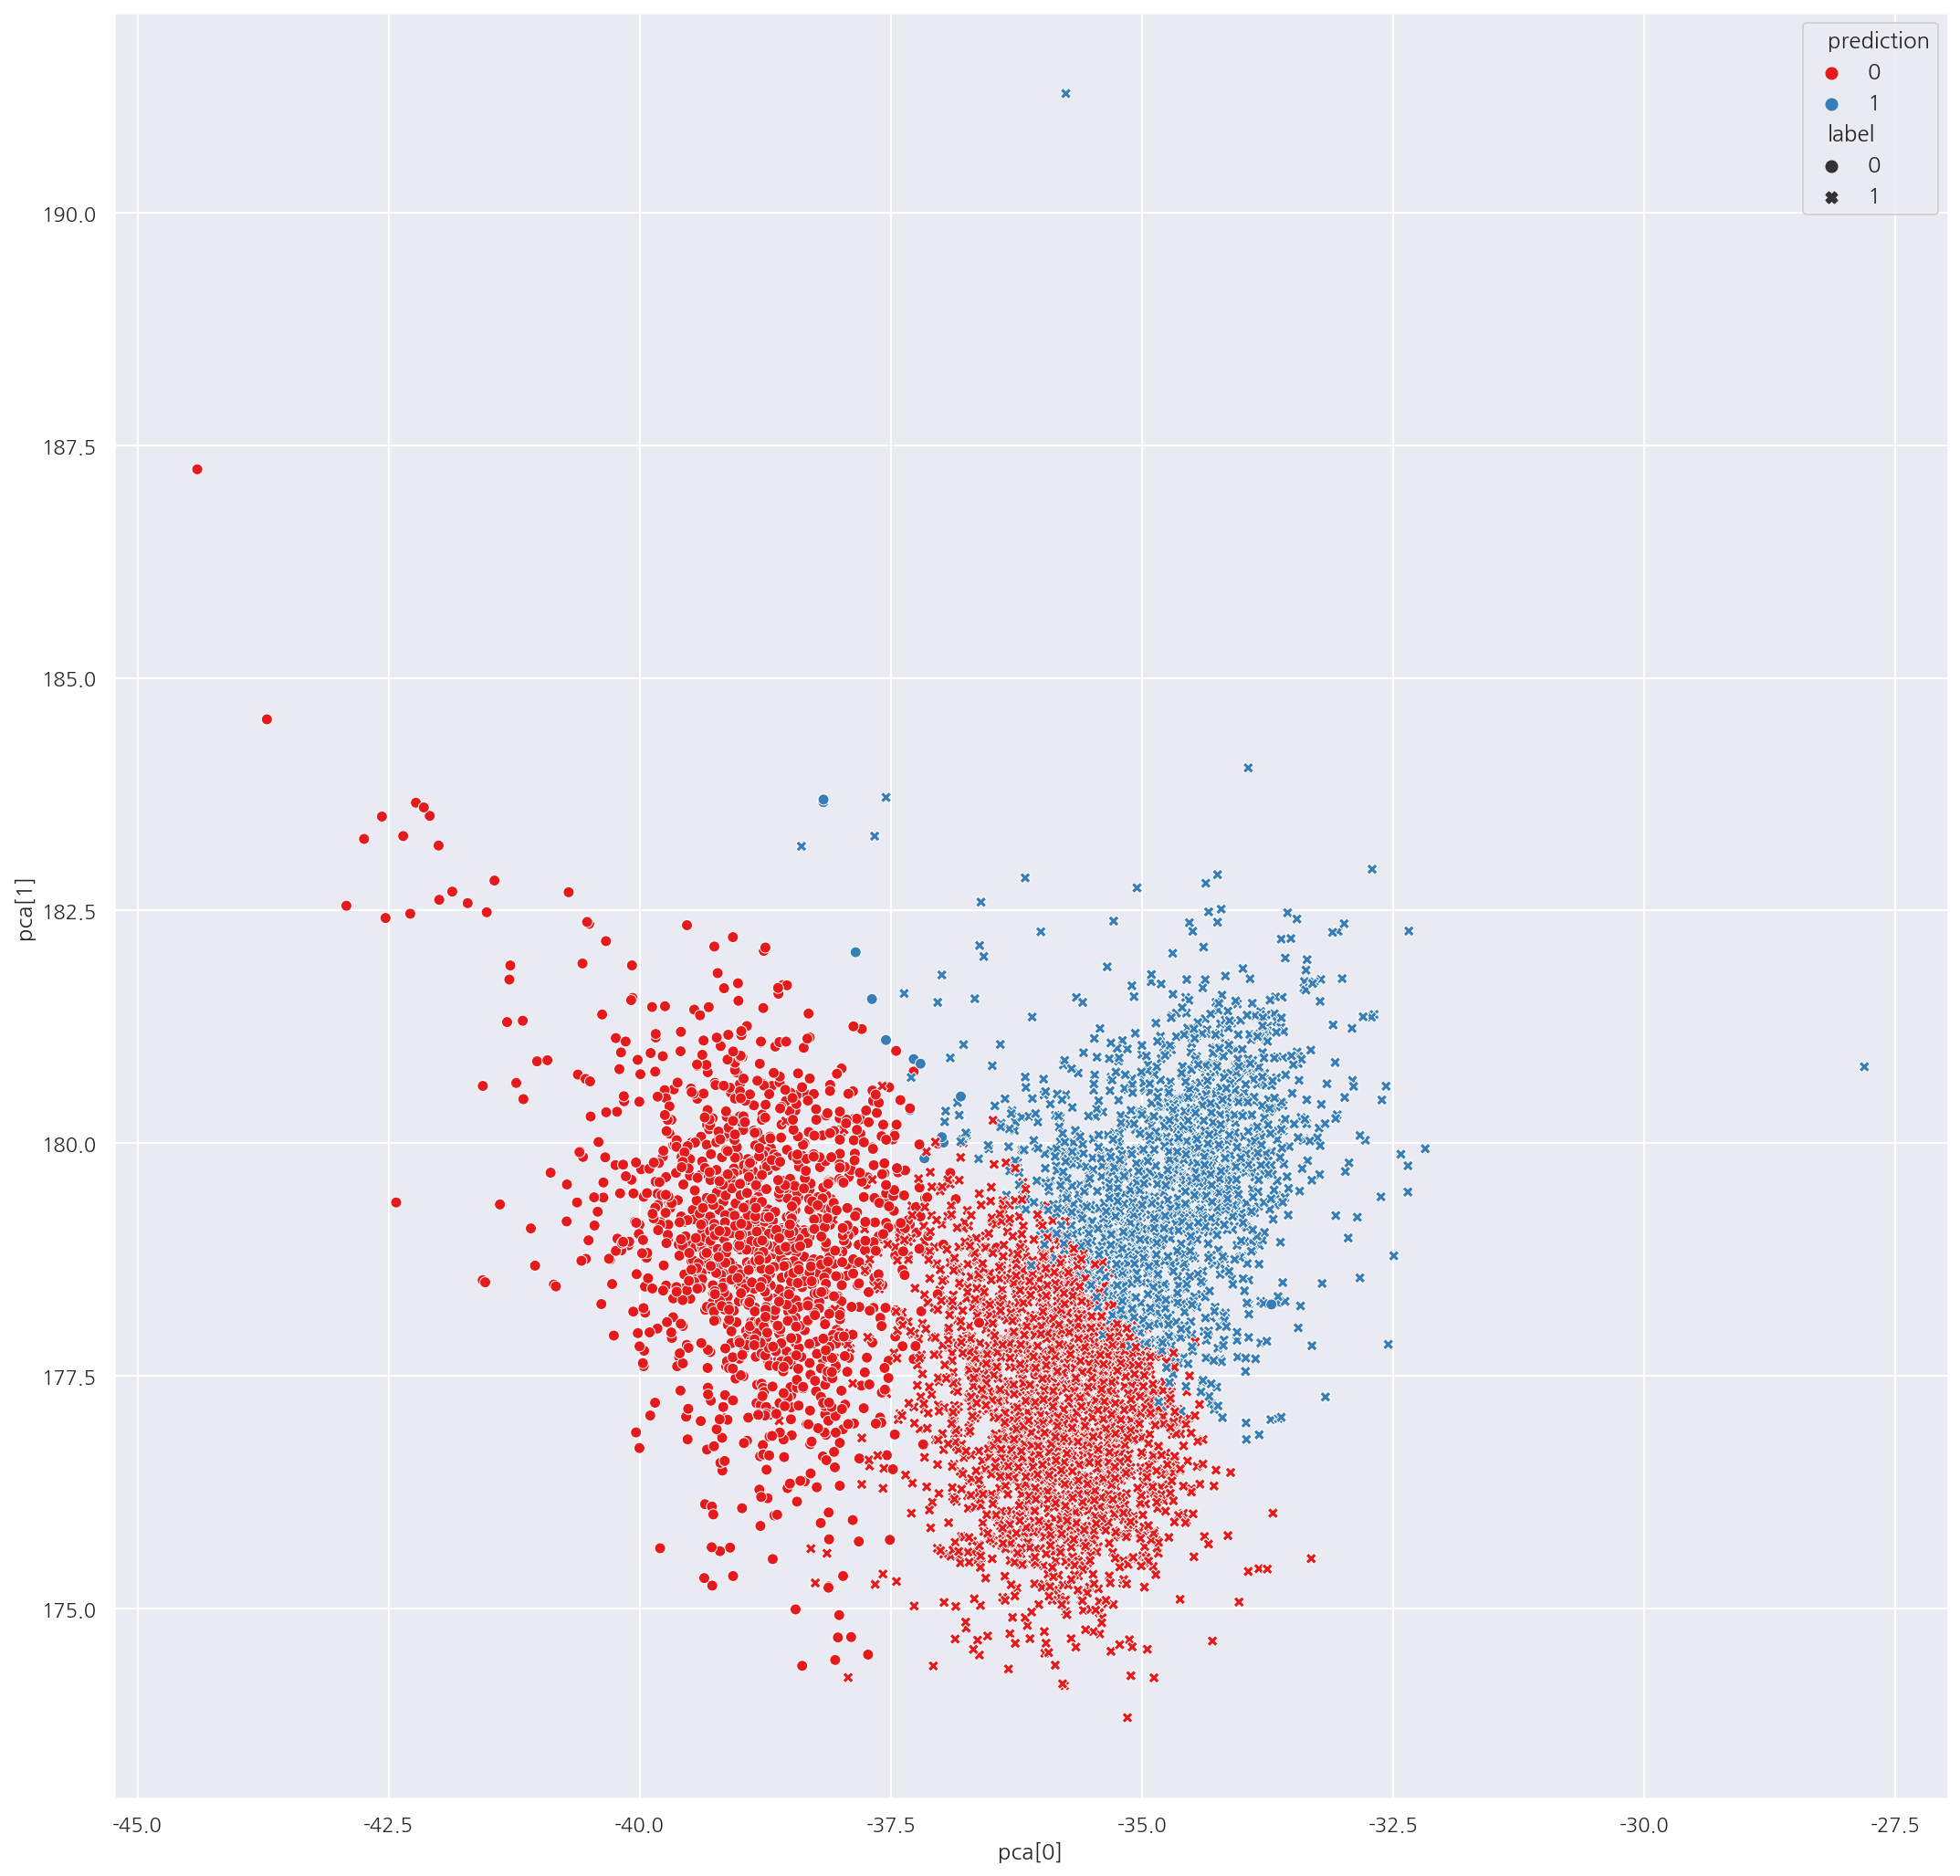

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 18))

ax = sns.scatterplot(x='pca[0]', y='pca[1]', hue='prediction', style='label', data=df_wine, palette="Set1")